# Analysis of time series

In [1]:
import numpy as np
import pandas as pd
from scipy import signal, stats
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
import tensorflow.random as tf_r

from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D

import seaborn 
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

%run plot.py

In [2]:
tf_r.set_seed(12345)
np.random.seed(12345)

EPOCHS=100
BATCH_SIZE = 250

### 2. Varying the amplitude $A$
Study the performance of the CNN by varying the amplitude $A$ of the patterns while keeping $DX$ fixed, namely by changing the signal-to-noise ratio.

N =  10000 	L =  60 	A =  200


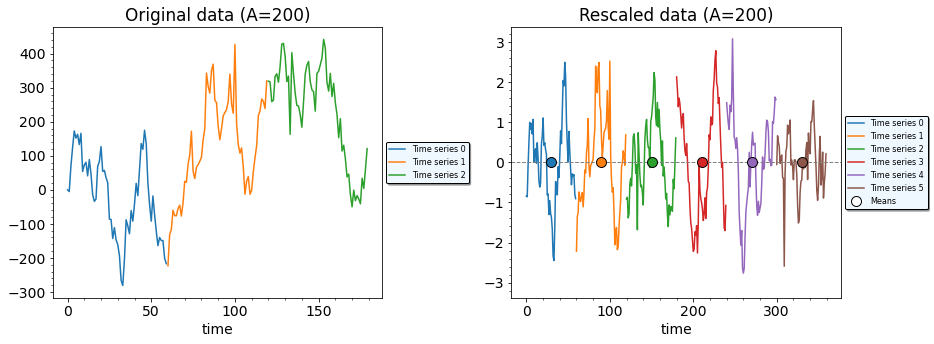

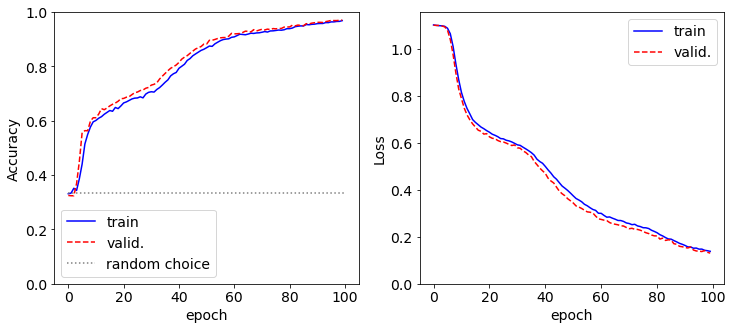

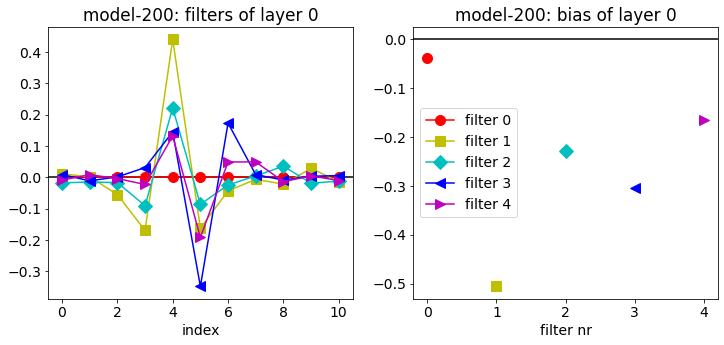

N =  10000 	L =  60 	A =  400


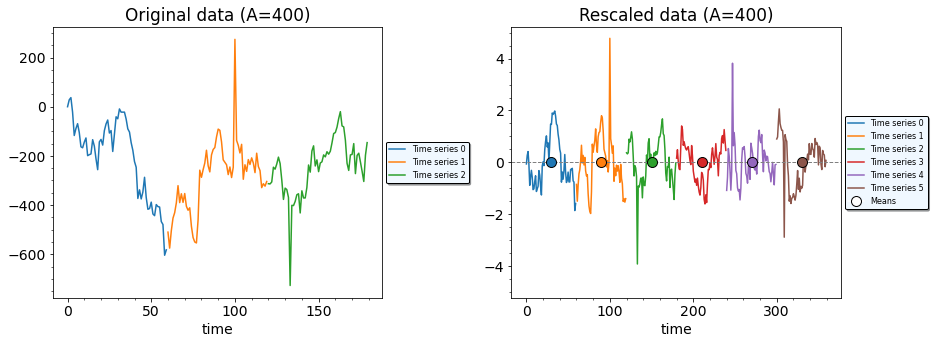

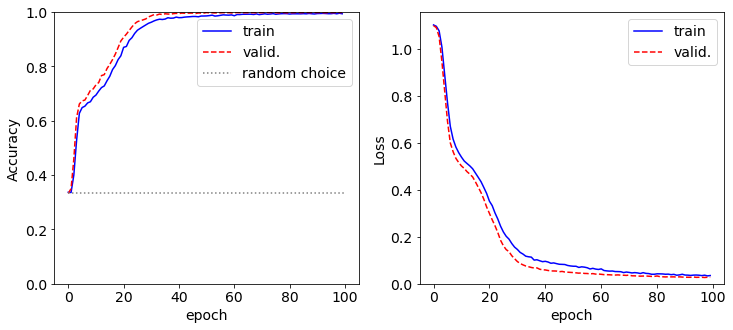

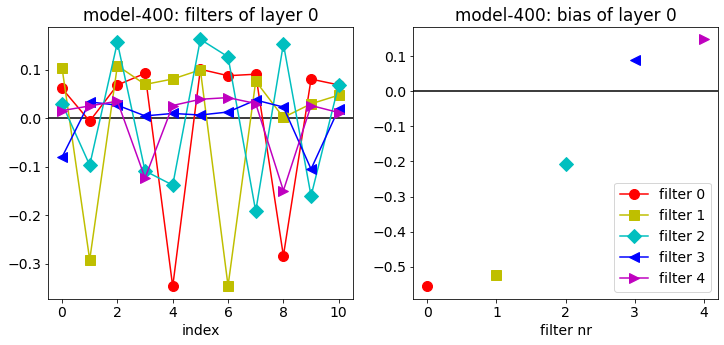

N =  10000 	L =  60 	A =  500


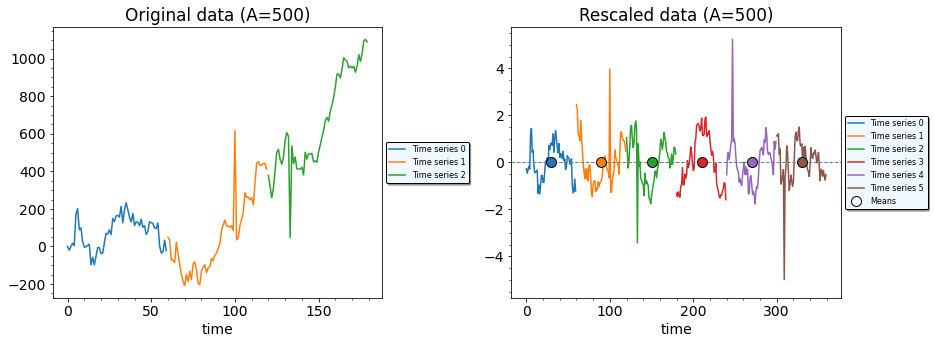

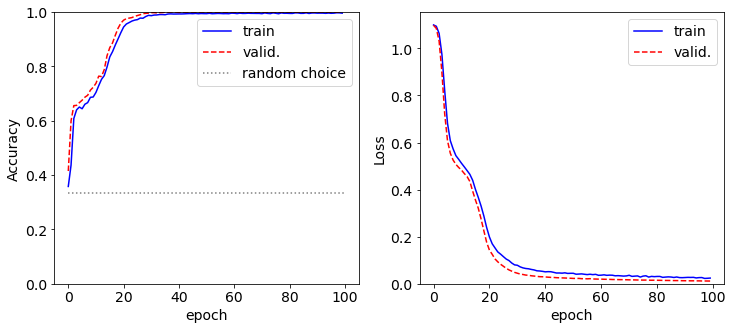

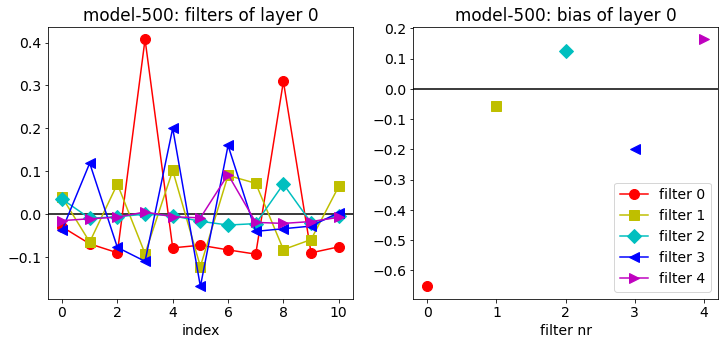

N =  10000 	L =  60 	A =  600


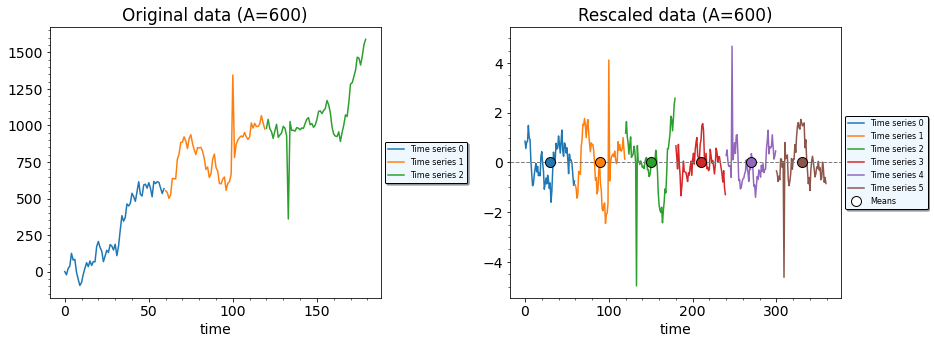

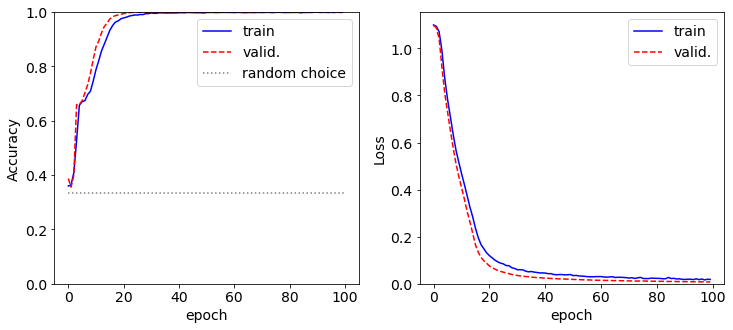

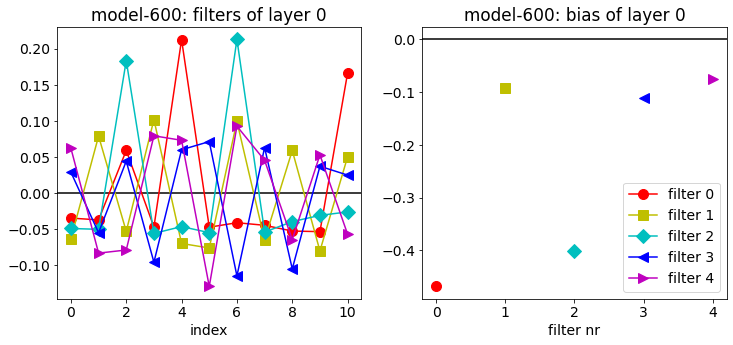

N =  10000 	L =  60 	A =  700


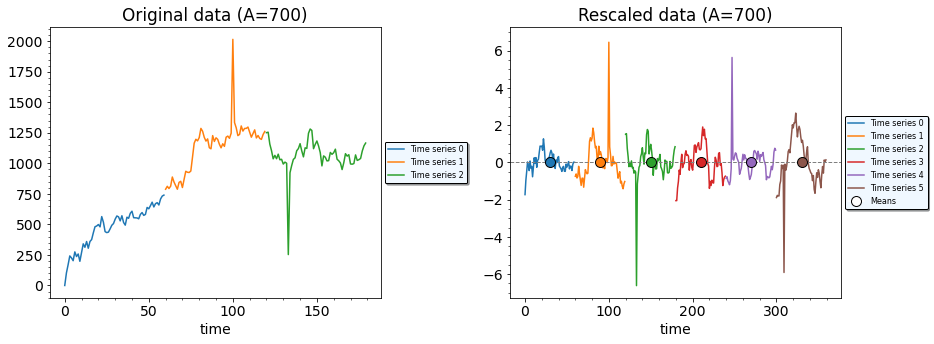

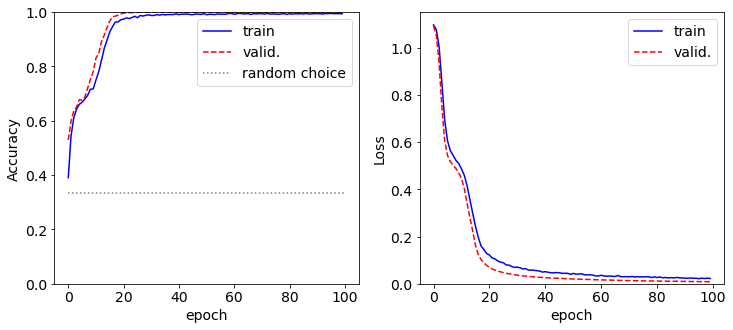

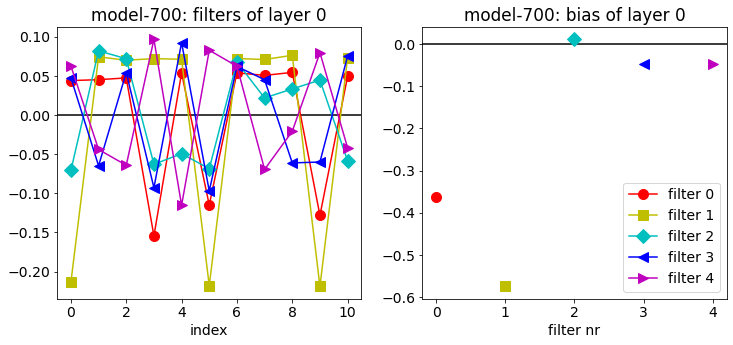

,Amplitude,Training loss,Test loss,Training Accuracy,Test Accuracy
0,200,0.110753,0.130425,0.972875,0.97
1,400,0.021962,0.027513,0.998,0.998
2,500,0.012078,0.011728,1.0,1.0
3,600,0.007949,0.007875,1.0,1.0
4,700,0.008822,0.00879,1.0,1.0


In [3]:
amp_vals = np.array([200, 400, 500, 600, 700])
df= pd.DataFrame(columns=['Amplitude', 'Training loss', 'Test loss', 'Training Accuracy', 'Test Accuracy'])

for amplitude in amp_vals:
    # Read the corresponding data
    fnamex = f'DATA/x_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'
    fnamey = f'DATA/y_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])
    print('N = ', N, '\tL = ', L , '\tA = ', amplitude)
    
    # Plot the first 3 samples
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    Show_data(x,L, f"Original data (A={amplitude})", nseries=3, A=None, axis=ax0, show=False)

    # Categories
    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1

    # Convert y to an (N x n_class) matrix
    # --> Directly pass to one hot encoding avoiding the for cycle
    y =tf.keras.utils.to_categorical(categ, n_class)
    
    # remove average value of each sample from its values (NON NECESSARY)
    # xm = x.mean(axis=1)

    # Preprocessing
    x_det = signal.detrend(x) # removes the tilt and centers the data
    x_det = x_det / np.std(x_det)
    
    # Plot the first 6 samples
    Show_data(x_det,L,f"Rescaled data (A={amplitude})", nseries=6, A=None, axis=ax1, show=False, dolegend=False)
    ax1.axhline(0, c="gray", linestyle='--', linewidth=1)
    low, high = plt.ylim()
    bound = bound = max(abs(low), abs(high))
    ax1.set_ylim(-bound, bound)
    # with their mean 
    for i in range(6):
        ax1.plot(L/2*(2*i+1), x_det[i].mean(), marker='o', markersize=10, 
                 markerfacecolor='C'+str(i), markeredgecolor='black')
    ax1.plot([],[], marker='o', markersize=10, markerfacecolor='white', markeredgecolor='black',
             label='Means', c='white')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
        shadow=True, framealpha=1, facecolor='aliceblue', edgecolor='black', prop={'size':8})
    plt.show()

    # Splitting into training and validation
    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x_det[:N_train]
    y_train = y[:N_train]
    x_val = x_det[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    #print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

    #x_train=x_train.astype("float32")
    #y_train=y_train.astype("float32")
    #x_val=x_val.astype("float32")
    #y_val=y_val.astype("float32")

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)

    
    # Regularizer and initializer    
    reg = regularizers.l2(0.02)# ridge with lambda
    #reg regularizerts.l1(0.1)
    ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)


    # Model
    NCONV = 1
    NF = 5 # number of filters

    model = Sequential()
    if NCONV == 1:
        model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                        kernel_regularizer=reg, activation = 'relu', 
                        input_shape=input_shape))
        
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7,
                        activation='relu'))
        model.add(Flatten())# To be sent to a normal neural network layer
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
        
    model.add(Dense(n_class, activation='softmax'))

    # Compile the model
    opt= tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])    
    BATCH_SIZE = 250
    EPOCHS = 100


    # Fit the model
    fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0, shuffle=True)
            
    eval_train = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    eval_test = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

    # Plot history, weights
    Show_history(fit)
    Show_weights(model,0,label="model"+str( - amplitude))

    
    # Save metrics in pd Dataframe
    df = pd.concat([df, pd.DataFrame(data=[[amplitude, eval_train[0], eval_test[0], eval_train[1], eval_test[1]]],
                                     columns=df.columns)
                    ], ignore_index=True)

display(df)

COMMENTI AI GRAFICI ............................

## 3. Grid Search for Regularization
Check if regularization may improve the performances by varying the parameter lambda (as usual in magnitude: $0$, $10^{-5}$, $10^{-4}$, $10^{-3}$, etc.) of the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed version (l1_l2) that can be tried.
- 3.1 Are performances of the CNN are optimized at some intermediate value of lambda?
- 3.2 Is there any improvement in the visualization and understanding of the weights in the
filters?

### Load the data
Here we use $A=400$.

In [5]:
# Load the data
A_selected = 400
fnamex = f'DATA/x_ts_L60_Z12_A{A_selected}_DX50_bias5_N10000.dat'
fnamey = f'DATA/y_ts_L60_Z12_A{A_selected}_DX50_bias5_N10000.dat'

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])
print('N = ', N, '\nL = ', L , '\nA = ', amplitude)

# Categories
categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    

# Convert y to an (N x n_class) matrix
# --> Directly pass to one hot encoding avoiding the for cycle
y =tf.keras.utils.to_categorical(categ, n_class)

# Preprocessing
x_det = signal.detrend(x) # removes the tilt and centers the data
x_det = x_det / np.std(x_det)


N =  10000 
L =  60 
A =  700


### Training and validation sets

In [6]:
# Splitting into training and validation
perc_train=0.8

N_train = int(perc_train*N)
x_train = x_det[:N_train]
y_train = y[:N_train]
x_val = x_det[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

### Grid search 

In [10]:
# Hyper-parameters

lambda_1 = 0.02
lambda_2 = 0.1
regl_2 = regularizers.l2(lambda_1)# ridge with lambda
reg_1 = regularizers.l1(lambda_2)
reg_1_2 = tf.keras.regularizers.l1_l2(l1=lambda_1, l2=lambda_2)


## 4. Best CNN modeled of 2020-2021 year
Try a CNN modeled around the best one of 2020-2021 year: three convolutional layers, no pooling, and the dense layer of the lesson replaced by a global max pooling. 

Is it working better? If yes, which could be the reason?

### Model

In [7]:
# Regularizer and initializer    
reg_2021 = regularizers.l2(0.02)
#reg regularizerts.l1(0.1)
ini_2021 = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)

NF = 6 # number of filters
model_2021 = Sequential()
model_2021.add(Conv1D(filters=NF, kernel_size=3, kernel_initializer=ini_2021,
                    kernel_regularizer=reg_2021, activation = 'relu', 
                    input_shape=input_shape))
    
model_2021.add(Conv1D(filters=8, kernel_size=9,
                activation='relu'))
model_2021.add(Conv1D(filters=4, kernel_size=3,
                activation='relu'))
model_2021.add(GlobalMaxPooling1D())
model_2021.add(Flatten())# To be sent to a normal neural network layer    
model_2021.add(Dense(n_class, activation='softmax'))
 
model_2021.summary() 


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 58, 6)             24        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 50, 8)             440       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 48, 4)             100       
_________________________________________________________________
global_max_pooling1d (Global (None, 4)                 0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 15        
Total params: 579
Trainable params: 579
Non-trainable params: 0
________________________________________________________

### Compile and fit the model

In [8]:
# Compile the model
opt= tf.keras.optimizers.Adam()
model_2021.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=opt, metrics=['accuracy'])    
BATCH_SIZE = 250
EPOCHS = 100

# Fit the model
fit = model_2021.fit(x_train, y_train, batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)
        
eval_train = model_2021.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
eval_test = model_2021.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

### Results

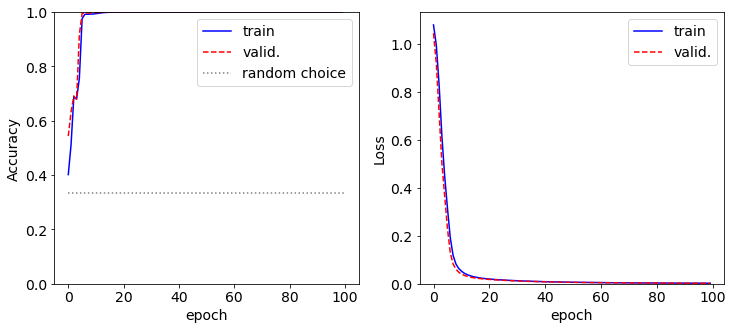

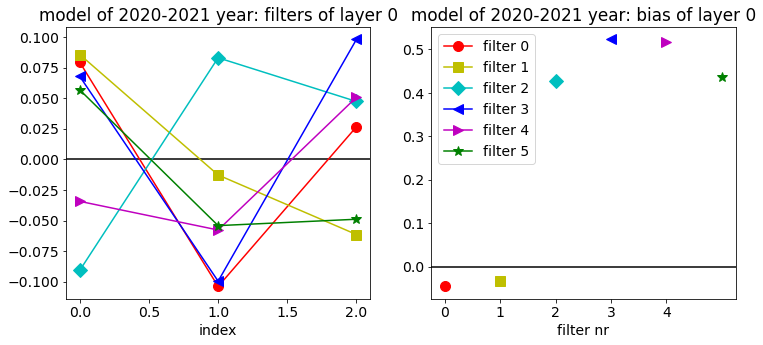

,Amplitude,Training loss,Test loss,Training Accuracy,Test Accuracy
0,200,0.110753,0.130425,0.972875,0.97
1,400,0.021962,0.027513,0.998,0.998
2,500,0.012078,0.011728,1.0,1.0
3,600,0.007949,0.007875,1.0,1.0
4,700,0.008822,0.00879,1.0,1.0
5,700,0.002301,0.002239,1.0,1.0


In [9]:
# Plot history, weights
Show_history(fit)
Show_weights(model_2021,0,label="model of 2020-2021 year")

# Save metrics in pd Dataframe
df_2021 = pd.concat([df, pd.DataFrame(data=[[amplitude, eval_train[0], eval_test[0], eval_train[1], eval_test[1]]],
                                     columns=df.columns)], ignore_index=True)
display(df_2021)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>